In [53]:
#!pip install pyradiomics

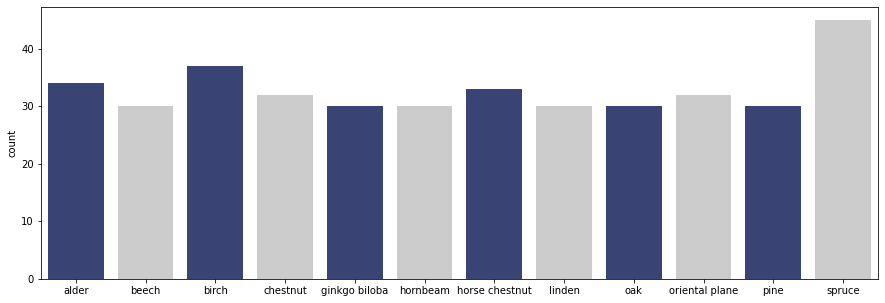

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# initalizing variables
data_dir = '../data/trunk12'
half_crop_s = 1500
new_s = 256
batch_size = 32
nii_dir = f'../data/trunk12_nii_{half_crop_s}_{new_s}'


# read images from the dataset directory
dataset = torchvision.datasets.ImageFolder(root=data_dir)


plt.figure(figsize=[15, 5])
p = sns.countplot(dataset.targets, palette=['#2F3C7E', '#CCCCCC'])
p.set_xticklabels(dataset.classes);

In [55]:

# generate a dataloader for the dataset
data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

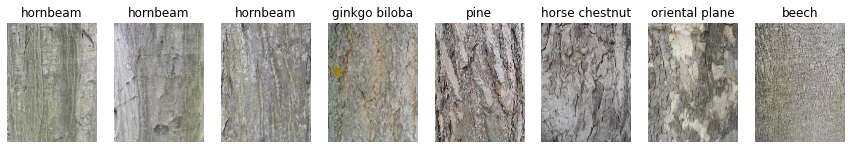

In [56]:
# show multiple examples of images from the training set
from PIL import Image
import random 
import torchvision.transforms as transforms

n = 8
indices = random.sample(range(0, len(dataset.imgs)),n)
batch = [dataset.imgs[i] for i in indices]
trans = transforms.ToTensor()

plt.figure(figsize=[15,5])
for i in range(n):
    img = Image.open(batch[i][0])
    img = trans(img)
    img = torch.permute(img, (1,2,0))
    target = dataset.classes[batch[i][1]]
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.title(target)
    plt.axis('off')
plt.show()


In [57]:
import numpy as np
import nibabel as nib
from PIL import Image, ImageOps
import os

imgs = dataset.imgs

for file, label in imgs:
    img = Image.open(file)
    w2 = int(img.size[0]/2)
    h2 = int(img.size[1]/2)
    img = ImageOps.grayscale(img)
    img = img.crop((w2-half_crop_s, h2-half_crop_s, w2+half_crop_s, h2+half_crop_s))
    img = img.resize((new_s,new_s))
    extrema = img.getextrema()
    arr = np.asarray(img).astype('float')
    arr = (arr - extrema[0])/ (extrema[1] - extrema[0]) * 255
    arr = np.expand_dims(arr, axis=2)
    #plt.imshow(img)
    #plt.show()
    empty_header = nib.Nifti1Header()
    affine =  np.eye(4)
    another_img = nib.Nifti1Image(arr, affine, empty_header)
    #print(another_img.header.get_data_shape())
    file = file.replace(data_dir, nii_dir)
    file = file.replace('.JPG', '.nii.gz')
    path = file.replace(file.split('/')[-1], "")
    os.makedirs(path, exist_ok = True)
    nib.save(another_img, file)

In [58]:
import nibabel as nib

img = nib.load(dataset.imgs[0][0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz'))
img.shape

(256, 256, 1)

In [59]:
import numpy as np
from PIL import Image

# save a mask file
mask = np.ones(img.shape) *255
mask[:1, :1, :] = 0
mask = mask.astype(np.uint8)
mask_name = "mask.nii.gz"
print(np.unique(np.asarray(mask)))

empty_header = nib.Nifti1Header()
affine = np.eye(4)
another_img = nib.Nifti1Image(mask, affine, empty_header)
print(another_img.header.get_data_shape())
nib.save(another_img, mask_name)

[  0 255]
(256, 256, 1)


In [60]:
import csv
import numpy as np

# write a csv file with location and label of each image in the train set
pyradiomics_header = ('Image','Mask', 'Label')
m_arr = [mask_name] * len(dataset.imgs)
img_label = dataset.imgs
rows = [(il[0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz'), m, 255) for m, il in zip(m_arr, img_label)]
rows.insert(0, pyradiomics_header)
arr = np.asarray(rows)
np.savetxt('pyradiomics_samples.csv', arr, fmt="%s", delimiter=",")



In [61]:
import radiomics
from radiomics import featureextractor 

print(img_label[0])
# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(force2D=True)
output = extractor.execute(img_label[0][0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz'), mask_name, label=255)


('../data/trunk12/alder/1.JPG', 0)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [62]:
import six 
# Make an array of the values
features = np.array([])

for key, value in six.iteritems(output):
    if key.startswith("original_"):
        features = np.append ( features, output[key])

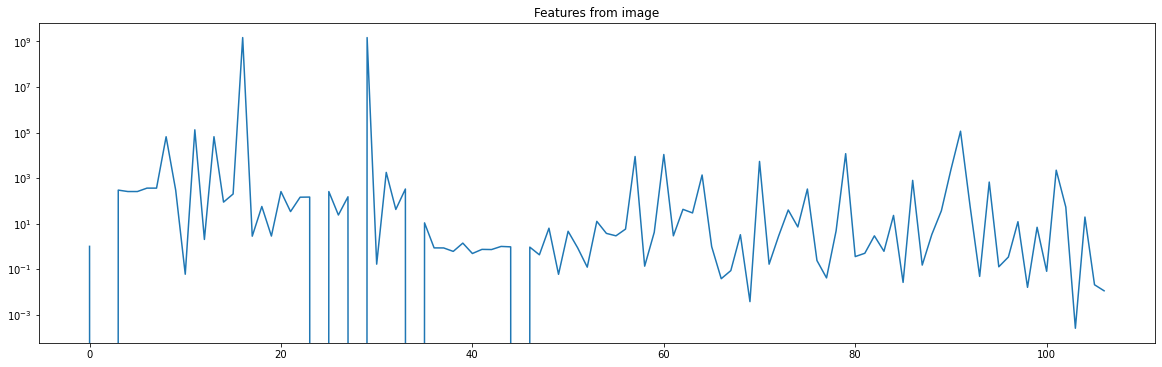

In [63]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.plot(features)
plt.yscale('log')
plt.title ( "Features from image");

In [66]:
# Run Pyradiomics on pyradiomics_sample.csv, output to pyradi.csv
!pyradiomics -o pyradi_features_{half_crop_s}_{new_s}.csv -f csv pyradiomics_samples.csv

21789.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[2022-09-14 08:00:27] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:00:49] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:01:12] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:01:34] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:01:57] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:02:19] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:02:42] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2022-09-14 08:03:04] W: radiomics.glcm: GLCM is symmet

In [66]:
import pandas as pd

# Declare csv Filename from Pyradiomics (zscore scaled and merged)
fname = f'pyradi_features_{half_crop_s}_{new_s}.csv'

# Load data
pyradi_data = pd.read_csv(fname)
pyradi_data.shape

(393, 132)

In [67]:
pyradi_original = pyradi_data.iloc[:,25:]
pyradi_original.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.999955,0.0,0.0,295.603338,256.0,256.0,361.332257,361.332257,65279.416667,295.589911,...,12.104198,0.015851,6.886770,0.080217,2214.768928,53.142371,0.000253,19.379408,0.020581,0.011179
1,0.999955,0.0,0.0,295.603338,256.0,256.0,361.332257,361.332257,65279.416667,295.589911,...,15.881813,0.023027,6.334346,0.155886,383.364534,73.054753,0.000210,26.244264,0.038473,0.008542
2,0.999955,0.0,0.0,295.603338,256.0,256.0,361.332257,361.332257,65279.416667,295.589911,...,13.678861,0.024074,6.451561,0.127871,469.861899,73.539947,0.000202,25.201974,0.026929,0.008719
3,0.999955,0.0,0.0,295.603338,256.0,256.0,361.332257,361.332257,65279.416667,295.589911,...,12.331515,0.021002,6.819170,0.102159,806.788041,65.192476,0.000225,21.980317,0.022867,0.009777
4,0.999955,0.0,0.0,295.603338,256.0,256.0,361.332257,361.332257,65279.416667,295.589911,...,13.723339,0.024042,6.486798,0.143053,290.539001,82.653074,0.000222,25.269331,0.038006,0.009020


In [45]:
pyradi_original['original_glcm_DifferenceAverage']

0      0.248192
1      0.354609
2      0.304546
3      0.268325
4      0.336424
         ...   
388    0.426299
389    0.429361
390    0.640455
391    0.757390
392    0.655091
Name: original_glcm_DifferenceAverage, Length: 393, dtype: float64

In [68]:
pyradi_original_norm = (pyradi_original - pyradi_original.min()) / (pyradi_original.max() - pyradi_original.min())
pyradi_original_norm['target'] = dataset.targets

In [69]:
pyradi_original_norm.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151151,0.679981,0.291483,0.005377,0.202390,0.304187,0.299529,0.228180,0.232303,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310481,0.411707,0.633200,0.000835,0.369408,0.207254,0.562607,0.480483,0.120486,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333723,0.468630,0.506684,0.001050,0.373478,0.189886,0.522664,0.317691,0.127998,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.265527,0.647153,0.390573,0.001885,0.303462,0.242174,0.399202,0.260412,0.172879,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333012,0.485742,0.575248,0.000605,0.449916,0.235787,0.525245,0.473900,0.140774,0


In [70]:
Y = pyradi_original_norm['target']
pyradi_original_norm = pyradi_original_norm.drop('target', axis=1)
pyradi_original_norm.shape

(393, 107)

In [71]:
pyradi_original_norm = pyradi_original_norm.dropna(axis=1, how='all')
pyradi_original_norm.shape

(393, 90)

In [72]:
for col in pyradi_original_norm.columns:
    print(col)

original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
original_glcm_Autocorrelation
original_glcm_ClusterProminence
original_glcm_ClusterShade
original_glcm_ClusterTendency
original_glcm_Contrast
original_glcm_Correlation
original_glcm_DifferenceAverage
original_glcm_DifferenceEntropy
original_glcm_DifferenceVariance
original_glcm_Id
original_glcm_Idm
original_glcm_Idmn
original_glcm_Idn
original_glcm_Imc1
original_glcm_Imc2
original_glcm_InverseVariance
original_glcm_JointAverage
original_glcm_JointEnergy
original_glcm_JointEntropy
original_glcm_MCC
original_

In [73]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
import statistics
from sklearn.metrics import matthews_corrcoef


def evaluate_model(model, df, calc_auc=False):
    auc_lr=[]
    pre_lr=[]
    rec_lr=[]
    acc_lr=[]
    f1_lr=[]
    auc_lrt=[]
    pre_lrt=[]
    rec_lrt=[]
    acc_lrt=[]
    f1_lrt=[]

    cv = StratifiedKFold(n_splits=7,  shuffle=False)
    for train_index, test_index in cv.split(df, Y):
       
        X_train, X_test = pyradi_original_norm.iloc[train_index], pyradi_original_norm.iloc[test_index]
        Y_train, Y_test= Y.iloc[train_index], Y.iloc[test_index]

        X_train= X_train.values
        X_test= X_test.values
        Y_train= Y_train.values
        Y_test= Y_test.values

        clf = make_pipeline(model)
        clf.fit(X_train, Y_train)

        pred = clf.predict(X_test)
        pre_l = precision_score(Y_test, pred, average='macro')
        rec_l = recall_score(Y_test, pred, average='macro')
        acc_l = accuracy_score(Y_test, pred)
        if calc_auc:
            probs = clf.predict_proba(X_test)
            auc_l = roc_auc_score(Y_test, probs, average='macro', multi_class='ovr')
        f1_l=f1_score(Y_test, pred, average='macro')

        pred = clf.predict(X_train)
        pre_lt = precision_score(Y_train, pred, average='macro')
        rec_lt = recall_score(Y_train, pred, average='macro')
        acc_lt = accuracy_score(Y_train, pred)
        if calc_auc:
            probs = clf.predict_proba(X_train)
            auc_lt = roc_auc_score(Y_train, probs, average='macro', multi_class='ovr')
        f1_lt = f1_score(Y_train, pred, average='macro')


        if calc_auc: auc_lr.append(auc_l)
        pre_lr.append(pre_l)
        rec_lr.append(rec_l)
        acc_lr.append(acc_l)
        f1_lr.append(f1_l)

        if calc_auc: auc_lrt.append(auc_lt)
        pre_lrt.append(pre_lt)
        rec_lrt.append(rec_lt)
        acc_lrt.append(acc_lt)
        f1_lrt.append(f1_lt)

    avg_auc_lrt = 0
    avg_pre_lrt = statistics.mean(pre_lrt)
    avg_rec_lrt = statistics.mean(pre_lrt)
    avg_acc_lrt = statistics.mean(acc_lrt)
    if calc_auc: avg_auc_lrt = statistics.mean(auc_lrt)
    avg_f1_lrt = statistics.mean(f1_lrt)

    avg_auc_lr = 0
    avg_pre_lr = statistics.mean(pre_lr)
    avg_rec_lr = statistics.mean(rec_lr)
    avg_acc_lr = statistics.mean(acc_lr)
    if calc_auc: avg_auc_lr = statistics.mean(auc_lr)
    avg_f1_lr = statistics.mean(f1_lr)

    return avg_pre_lrt, avg_rec_lrt, avg_acc_lrt, avg_auc_lrt, avg_f1_lrt, avg_pre_lr, avg_rec_lr, avg_acc_lr, avg_auc_lr, avg_f1_lr

In [74]:
from xgboost import XGBClassifier

calc_auc = True
model = XGBClassifier(n_estimators=1000, max_depth=1, learning_rate=0.5, min_child_weight=5)
stats_xgb = evaluate_model(model, pyradi_original_norm, calc_auc)

print("TRAIN:")
print("PRE:", stats_xgb[0])
print("REC:", stats_xgb[1])
print("ACC:", stats_xgb[2])
if calc_auc: print("AUC:", stats_xgb[3])
print("F1:", stats_xgb[4])

print("TEST:")
print("PRE:", stats_xgb[5])
print("REC:", stats_xgb[6])
print("ACC:", stats_xgb[7])
if calc_auc: print("AUC:", stats_xgb[8])
print("F1:", stats_xgb[9])

TRAIN:
PRE: 0.9995421245421245
REC: 0.9995421245421245
ACC: 0.9995760915642221
AUC: 1.0
F1: 0.9995331465919701
TEST:
PRE: 0.649253590325019
REC: 0.6443310657596372
ACC: 0.6563730755460079
AUC: 0.9337057701698019
F1: 0.6258990678633536


In [75]:
from sklearn.svm import SVC

calc_auc = True
model = SVC(kernel='poly', degree=4, probability=True)
stats_svc = evaluate_model(model, pyradi_original_norm, calc_auc)

print("TRAIN:")
print("PRE:", stats_svc[0])
print("REC:", stats_svc[1])
print("ACC:", stats_svc[2])
if calc_auc: print("AUC:", stats_svc[3])
print("F1:", stats_svc[4])

print("TEST:")
print("PRE:", stats_svc[5])
print("REC:", stats_svc[6])
print("ACC:", stats_svc[7])
if calc_auc: print("AUC:", stats_svc[8])
print("F1:", stats_svc[9])



TRAIN:
PRE: 0.9168952240095384
REC: 0.9168952240095384
ACC: 0.9130583984335574
AUC: 0.9939160003165296
F1: 0.9109392024086682
TEST:
PRE: 0.6936366213151928
REC: 0.6927437641723356
ACC: 0.6994718940207661
AUC: 0.9521619940937681
F1: 0.6740596393957738


In [76]:
from sklearn.ensemble import RandomForestClassifier

calc_auc = True
model = RandomForestClassifier(max_samples=0.8, n_estimators=30)
stats_rf = evaluate_model(model, pyradi_original_norm, calc_auc)

print("TRAIN:")
print("PRE:", stats_rf[0])
print("REC:", stats_rf[1])
print("ACC:", stats_rf[2])
if calc_auc: print("AUC:", stats_rf[3])
print("F1:", stats_rf[4])

print("TEST:")
print("PRE:", stats_rf[5])
print("REC:", stats_rf[6])
print("ACC:", stats_rf[7])
if calc_auc: print("AUC:", stats_rf[8])
print("F1:", stats_rf[9])


TRAIN:
PRE: 0.9943609280649268
REC: 0.9943609280649268
ACC: 0.9936363269343346
AUC: 0.9999563818101364
F1: 0.9937283787160256
TEST:
PRE: 0.6137110904968047
REC: 0.5905328798185941
ACC: 0.6004296455424275
AUC: 0.9129917572572407
F1: 0.5767624843255095


In [77]:
from sklearn.linear_model import LogisticRegression
  
calc_auc = True
model = LogisticRegression(max_iter=10000, penalty='none')
stats_lr = evaluate_model(model, pyradi_original_norm, calc_auc)

print("TRAIN:")
print("PRE:", stats_lr[0])
print("REC:", stats_lr[1])
print("ACC:", stats_lr[2])
if calc_auc: print("AUC:", stats_lr[3])
print("F1:", stats_lr[4])

print("TEST:")
print("PRE:", stats_lr[5])
print("REC:", stats_lr[6])
print("ACC:", stats_lr[7])
if calc_auc: print("AUC:", stats_lr[8])
print("F1:", stats_lr[9])


TRAIN:
PRE: 1.0
REC: 1.0
ACC: 1.0
AUC: 1.0
F1: 1.0
TEST:
PRE: 0.6924461451247166
REC: 0.6762471655328798
ACC: 0.6791084854994629
AUC: 0.948374401507935
F1: 0.6612985559414131


In [78]:
from sklearn.linear_model import SGDClassifier

calc_auc = False
model = SGDClassifier(loss='modified_huber',class_weight='balanced')
stats_sgd = evaluate_model(model, pyradi_original_norm, calc_auc)

print("TRAIN:")
print("PRE:", stats_sgd[0])
print("REC:", stats_sgd[1])
print("ACC:", stats_sgd[2])
if calc_auc: print("AUC:", stats_sgd[3])
print("F1:", stats_sgd[4])

print("TEST:")
print("PRE:", stats_sgd[5])
print("REC:", stats_sgd[6])
print("ACC:", stats_sgd[7])
if calc_auc: print("AUC:", stats_sgd[8])
print("F1:", stats_sgd[9])    

TRAIN:
PRE: 0.6513322665853067
REC: 0.6513322665853067
ACC: 0.555561022628636
F1: 0.5151172409364095
TEST:
PRE: 0.49110234551024023
REC: 0.5072562358276644
ACC: 0.5111886860007161
F1: 0.44600167472924895


In [57]:
stats_xgb = list(stats_xgb)
stats_svc = list(stats_svc)
stats_rf = list(stats_rf)
stats_lr = list(stats_lr)
stats_sgd = list(stats_sgd)

In [58]:
from itertools import zip_longest
import csv

names = ['PRE_train', 'REC_train', 'ACC_train', 'AUC_train', 'F1_train', 
         'PRE_test', 'REC_test', 'ACC_test', 'AUC_test', 'F1_test']
rows = [names, stats_xgb, stats_svc, stats_rf, stats_lr, stats_sgd]
export_data = zip_longest(*rows, fillvalue = '')
filename = f'./stats_crop_s_{half_crop_s}_new_s_{new_s}.csv'
with open(filename, 'w', encoding="ISO-8859-1", newline='') as f:
      wr = csv.writer(f)
      wr.writerow(("Classifier", "XGBoost", "SVM", "RandomForest", "LinearRegression", "SGD"))
      wr.writerows(export_data)
f.close()